### Import Libraries and Initialise Parameters

In [ ]:
!wget -nc https://leephilipx.github.io/OFDM/Pilot_64
!wget -nc https://leephilipx.github.io/OFDM/utilsOFDMfunc_final.py

import numpy as np
import tensorflow as tf
from utilsOFDMfunc_final import *
from tqdm import tqdm
from tqdm.keras import TqdmCallback
import scipy.io
import matplotlib.pyplot as plt

File ‘Pilot_64’ already there; not retrieving.

File ‘utilsOFDMfunc_final.py’ already there; not retrieving.



In [ ]:
## OFDM Parameters
params = {}
params['K'] = 64                      # Number of subcarriers
params['P'] = 64                      # Number of pilots
params['CP'] = params['K']//4         # Length of cyclic prefix
params['mu'] = 2                      # QPSK, 2 bits per symbol
params['snrDB'] = 20                  # Signal to noise-ratio in dB at the receiver
params['n_bits'] = params['K'] * params['mu']
params['n_bits_out'] = 128

mapping_table = {
    (0,0) : -1-1j,
    (0,1) : -1+1j,
    (1,0) : 1-1j,
    (1,1) : 1+1j,
}

demapping_table = {v : k for k, v in mapping_table.items()}

params['pilotSymbols'] = generate_pilots(params['P'], params['mu'])
channel_response_set_train, channel_response_set_test = generate_channel_response_set()

• Pilot file loaded: Pilot_64


ValueError: ignored

### Modelling Once

In [ ]:
params['removeCP_bool'] = False
params['clipping_bool'] = False

model = instantiate_DL_model(params)
lrs, checkpoint = instantiate_callbacks()

ofdm_generator_train = ofdm_gen(20, 'train', params, channel_response_set_train, channel_response_set_test)
ofdm_generator_test = ofdm_gen(20, 'test', params, channel_response_set_train, channel_response_set_test)

Instantiating deep learning model 'channel_estimation_stack'
>> Each stack predicts 8 bits, with a total of 16 stacks predicting 128 total bits!


In [ ]:
history = model.fit(ofdm_generator_train, steps_per_epoch=50, epochs=20, validation_data=ofdm_generator_test,
                    validation_steps=1, callbacks=[checkpoint, lrs, TqdmCallback()], verbose=2); # verbose 1/2

Epoch 1/20
50/50 - 19s - loss: 0.6789 - bit_err: 0.4230 - val_loss: 0.6395 - val_bit_err: 0.3352
Epoch 2/20
50/50 - 14s - loss: 0.5483 - bit_err: 0.2593 - val_loss: 0.4409 - val_bit_err: 0.1830
Epoch 3/20
50/50 - 15s - loss: 0.3315 - bit_err: 0.1226 - val_loss: 0.2374 - val_bit_err: 0.0753
Epoch 4/20
50/50 - 15s - loss: 0.1699 - bit_err: 0.0481 - val_loss: 0.1182 - val_bit_err: 0.0295
Epoch 5/20
50/50 - 15s - loss: 0.0867 - bit_err: 0.0200 - val_loss: 0.0657 - val_bit_err: 0.0148
Epoch 6/20
50/50 - 15s - loss: 0.0520 - bit_err: 0.0119 - val_loss: 0.0427 - val_bit_err: 0.0100
Epoch 7/20
50/50 - 15s - loss: 0.0377 - bit_err: 0.0095 - val_loss: 0.0352 - val_bit_err: 0.0093
Epoch 8/20
50/50 - 15s - loss: 0.0308 - bit_err: 0.0084 - val_loss: 0.0307 - val_bit_err: 0.0090
Epoch 9/20
50/50 - 15s - loss: 0.0270 - bit_err: 0.0079 - val_loss: 0.0255 - val_bit_err: 0.0075
Epoch 10/20
50/50 - 15s - loss: 0.0240 - bit_err: 0.0073 - val_loss: 0.0244 - val_bit_err: 0.0078
Epoch 11/20
50/50 - 15s - los

dict_keys(['loss', 'bit_err', 'val_loss', 'val_bit_err', 'lr'])



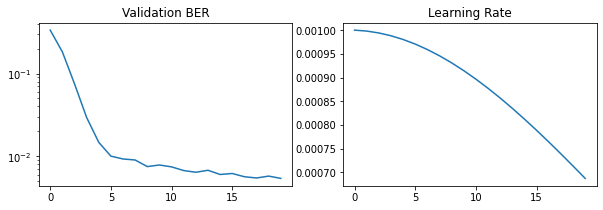

In [ ]:
print(history.history.keys(), end='\n\n')

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].semilogy(history.history['val_bit_err'])
ax[0].set_title('Validation BER')
ax[1].plot(history.history['lr'])
ax[1].set_title('Learning Rate');

In [ ]:
snrDB_list = range(0, 25, 4)
BER_ = evaluate_model(model, params, snrDB_list, Krice=20, channel_len=3)

100%|██████████| 7/7 [00:16<00:00,  2.32s/it]


In [ ]:
scipy.io.savemat('BER_' + instance_name + '_' + str(channel_len_test) + '.mat',
                 {'snrDB_list': snrDB_list, 'BER_Krice_neg40': BER_Krice_neg40,
                  'BER_Krice_10': BER_Krice_10, 'BER_Krice_20': BER_Krice_20})

Evaluate BER for snrDB: 100%|██████████| 7/7 [01:13<00:00, 10.49s/it]


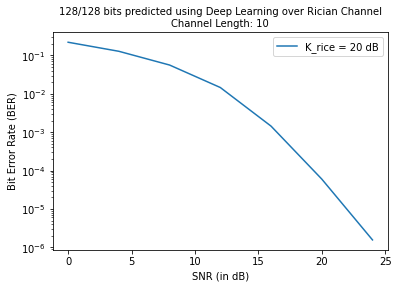

In [ ]:
plt.semilogy(snrDB_list, BER); 
plt.legend(['K_rice = 20 dB']);
plt.xlabel('SNR (in dB)');
plt.ylabel('Bit Error Rate (BER)');
plt.title(f'128/128 bits predicted using Deep Learning over Rician Channel\nChannel Length: 10', size=10);

### 4.1 Impact of *n_bits_out*

In [ ]:
params['n_bits_out'] = 64
params['removeCP_bool'] = False
params['clipping_bool'] = False

model = instantiate_DL_model_old(params)
lrs, checkpoint = instantiate_callbacks()

ofdm_generator_train = ofdm_gen(20, 'train', params, channel_response_set_train, channel_response_set_test)
ofdm_generator_test = ofdm_gen(20, 'test', params, channel_response_set_train, channel_response_set_test)

history = model.fit(ofdm_generator_train, steps_per_epoch=50, epochs=1, validation_data=ofdm_generator_test,
                    validation_steps=1, callbacks=[checkpoint, lrs, TqdmCallback()], verbose=0);

Instantiating deep learning model 'channel_estimation_old'


dict_keys(['loss', 'bit_err', 'val_loss', 'val_bit_err', 'lr'])



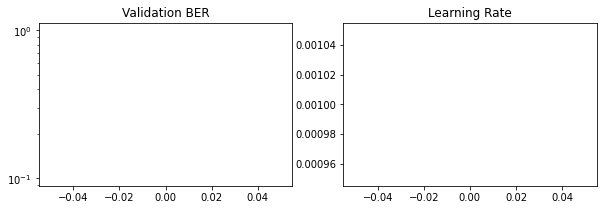

In [ ]:
print(history.history.keys(), end='\n\n')

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].semilogy(history.history['val_bit_err'])
ax[0].set_title('Validation BER')
ax[1].plot(history.history['lr'])
ax[1].set_title('Learning Rate');

In [ ]:
history.history['val_bit_err'][0]

0.3991367220878601

In [ ]:
export = {
    'n_bits_out': [2, 4, 8, 16, 32, 64, 128],
    'val_bit_err': [0.00274, 0.002375, 0.003125, 0.003469, 0.006281, 0.020133, 0.130832],
    'epochs': [8, 10, 20, 32, 45, 61, 73],
}

scipy.io.savemat('4_1_impact_of_n_bits_out.mat', export)

### 5.1 Impact of Train Set Noise

In [ ]:
BERs = {}
models = []
params['removeCP_bool'] = False
params['clipping_bool'] = False
snrDB_list = range(0, 21, 4)

for snrDB in [5, 10, 15, 20, 25, 30]:
    print(f'>> TEST/snrDB/{snrDB}')
    model = instantiate_DL_model(params, verbose=False)
    lrs, checkpoint = instantiate_callbacks()
    ofdm_generator_train = ofdm_gen(snrDB, 'train', params, channel_response_set_train, channel_response_set_test)
    ofdm_generator_test = ofdm_gen(20, 'test', params, channel_response_set_train, channel_response_set_test)   
    history = model.fit(ofdm_generator_train, steps_per_epoch=50, epochs=20, validation_data=ofdm_generator_test,
                        validation_steps=1, callbacks=[checkpoint, lrs, TqdmCallback()], verbose=0)
    BERs[f'snrDB_{snrDB}'] = evaluate_model(model, params, snrDB_list, Krice=20, channel_len=10)
    models.append(model)

scipy.io.savemat('5_1_impact_of_train_set_noise.mat', BERs)

>> TEST/snrDB/5


100%|██████████| 6/6 [00:16<00:00,  2.79s/it]


>> TEST/snrDB/10


100%|██████████| 6/6 [00:16<00:00,  2.71s/it]


>> TEST/snrDB/15


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:15<00:00,  2.50s/it]


>> TEST/snrDB/20


100%|██████████| 6/6 [00:15<00:00,  2.56s/it]


>> TEST/snrDB/25


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:16<00:00,  2.78s/it]


>> TEST/snrDB/30


100%|██████████| 6/6 [00:17<00:00,  2.88s/it]


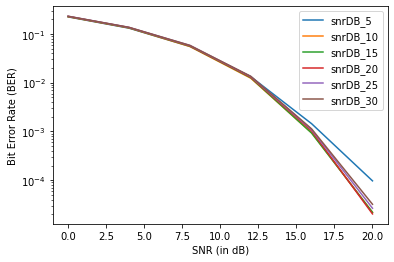

In [ ]:
for ber in BERs.values():
    plt.semilogy(snrDB_list, ber); 
plt.legend(BERs.keys());
plt.xlabel('SNR (in dB)');
plt.ylabel('Bit Error Rate (BER)');

In [ ]:
for model, snrDB in zip(models, [5, 10, 15, 20, 25, 30]):
    model.save(f'5_1_model_snrDB_{snrDB}.h5')

In [ ]:
!find . -name '5_1_model*' | zip '5_1_models.zip' -@

updating: 5_1_model_snrDB_5.h5 (deflated 14%)
updating: 5_1_model_snrDB_25.h5 (deflated 14%)
updating: 5_1_model_snrDB_20.h5 (deflated 14%)
updating: 5_1_model_snrDB_10.h5 (deflated 14%)
updating: 5_1_model_snrDB_15.h5 (deflated 14%)
updating: 5_1_model_snrDB_30.h5 (deflated 14%)


### 5.5 Evaluation Time

In [ ]:
!wget -nc https://leephilipx.github.io/OFDM/utilsOFDMfunc_legacy.py
!wget -nc https://leephilipx.github.io/OFDM/OFDM_DLstack_20epoch_normal.h5

from utilsOFDMfunc_legacy import *

params['removeCP_bool'] = False
params['clipping_bool'] = False
model = instantiate_DL_model(params)
model.load_weights('OFDM_DLstack_20epoch_normal.h5')
DL_test_data, DL_test_bits = next(ofdm_gen_single(snrDB=20, K_rice=-40, channel_len=10, params=params))

n_bits = 128
x_s, Tx, demapping_table, fft_remainder, pilotData = transmitter(n_bits)
channelResponse = generate_rician_channel(K_rice=-40, channel_len=10)
y_s, noise_var_1D = channel_H_2(signal=x_s, snrDB=20, channelResponse=channelResponse)

print('Length of x_s =', len(x_s))
print('Length of y_s =', len(y_s))
print('noise_var_1D = ', noise_var_1D)

File ‘utilsOFDMfunc_legacy.py’ already there; not retrieving.

File ‘OFDM_DLstack_20epoch_normal.h5’ already there; not retrieving.

Instantiating deep learning model 'channel_estimation_stack'
>> Each stack predicts 8 bits, with a total of 16 stacks predicting 128 total bits!
Length of x_s = 160
Length of y_s = 160
noise_var_1D =  0.009468100868726351


In [ ]:
%%timeit -n 50
np.round(model.predict(DL_test_data)).astype(int)

50 loops, best of 5: 34.6 ms per loop


In [ ]:
%%timeit -n 1000
receiver_LS(y_s, fft_remainder, demapping_table, pilotData, n_fft=64)

1000 loops, best of 5: 494 µs per loop


In [ ]:
%%timeit -n 50
receiver_LMMSE(y_s, fft_remainder, demapping_table, pilotData, noise_var_1D, fade_var_1D=0.5, n_fft=64, channel_length=6)

50 loops, best of 5: 29 ms per loop


In [ ]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()
open('tf_lite_model.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmppeikprxu/assets


INFO:tensorflow:Assets written to: /tmp/tmppeikprxu/assets


2816744

In [ ]:
interpreter = tf.lite.Interpreter(model_path = 'tf_lite_model.tflite')
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 256]
Input Type: <class 'numpy.float32'>
Output Shape: [  1 128]
Output Type: <class 'numpy.float32'>


In [ ]:
%%timeit
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], DL_test_data.astype('float32'))
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
np.round(tflite_model_predictions).astype(int)

The slowest run took 5.16 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 128 µs per loop


In [ ]:
Rx = receiver_LS(y_s, fft_remainder, demapping_table, pilotData, n_fft=64)
print('LS:', np.mean(np.abs(Rx - Tx)))

Rx = receiver_LMMSE(y_s, fft_remainder, demapping_table, pilotData, noise_var_1D, fade_var_1D=0.5, n_fft=64, channel_length=2)
print('LMMSE:', np.mean(np.abs(Rx - Tx)))

interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], DL_test_data.astype('float32'))
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
Rx = np.round(tflite_model_predictions).astype(int)
print('DL:', np.mean(np.abs(Rx - DL_test_bits)))

Rx = np.round(model.predict(DL_test_data)).astype(int)
print('DL (tflite):', np.mean(np.abs(Rx - DL_test_bits)))

LS: 0.0625
LMMSE: 0.25
DL: 0.03125
DL (tflite): 0.03125


100%|██████████| 6/6 [00:11<00:00,  1.88s/it]


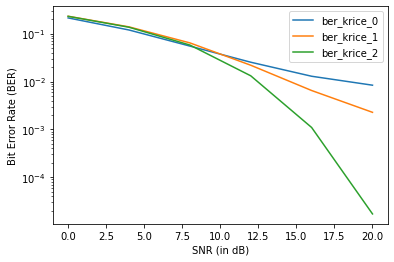

In [ ]:
interpreter.resize_tensor_input(input_details[0]['index'], (10000, 256))
interpreter.resize_tensor_input(output_details[0]['index'], (10000, 128))

def evaluate_model_tflite(interpreter, params, snrDB_list, Krice, channel_len):
    BER_list = []
    for snrDB in tqdm(snrDB_list):
        X_BER, y_BER = next(ofdm_gen_BER(snrDB, Krice, channel_len, params))
        interpreter.allocate_tensors()
        interpreter.set_tensor(input_details[0]['index'], X_BER.astype('float32'))
        interpreter.invoke()
        tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
        preds_BER = np.round(tflite_model_predictions).astype(int)
        BER_list.append(np.mean(np.abs(y_BER - preds_BER)))
    return np.array(BER_list)

snrDB_list = range(0, 21, 4)
BERs = {f'ber_krice_{i}': evaluate_model_tflite(interpreter, params, snrDB_list, Krice=krice, channel_len=10)
        for i, krice in enumerate([-40, 10, 20])}

for ber in BERs.values():
    plt.semilogy(snrDB_list, ber); 
plt.legend(BERs.keys());
plt.xlabel('SNR (in dB)');
plt.ylabel('Bit Error Rate (BER)');

scipy.io.savemat('data_5_5_1_tflite.mat', BERs)

100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


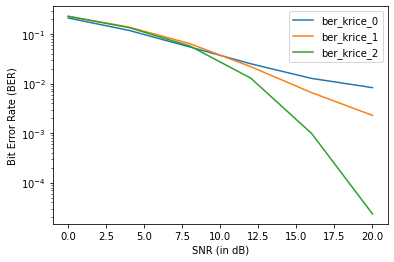

In [ ]:
snrDB_list = range(0, 21, 4)
BERs = {f'ber_krice_{i}': evaluate_model(model, params, snrDB_list, Krice=krice, channel_len=10)
        for i, krice in enumerate([-40, 10, 20])}

for ber in BERs.values():
    plt.semilogy(snrDB_list, ber); 
plt.legend(BERs.keys());
plt.xlabel('SNR (in dB)');
plt.ylabel('Bit Error Rate (BER)');

scipy.io.savemat('data_5_5_1_normal_DL_model.mat', BERs)